In [1]:
import jax
import jax.numpy as jnp
import croissant as cro
import croissant.jax as crojax
import matplotlib.pyplot as plt
from functools import partial
from healpy import get_nside, projview
import numpy as np
import lunarsky
import s2fft
import healpy as hp
from lunarsky import Time
from astropy.units import s as seconds
from tqdm.notebook import trange

In [2]:
world = "earth"
lmax = 64 # maximal harmonic band limit given sampling of beam, inclusive
# freq = jnp.arange(50, 251)
ntimes = 10
dt = cro.constants.sidereal_day[world] / ntimes
phases = crojax.simulator.rot_alm_z(lmax, ntimes, dt, world=world)

data = jnp.load('/home/dominiv/simulink/dac/notebooks/eigsep_vivaldi.npz')

vivaldi_hp = data['bm']
freq = data['freqs']/1e6
nside = 32
vivaldi_hp = hp.ud_grade(vivaldi_hp, nside, power=-2)
npix = hp.nside2npix(nside)

fmin = 50
fmax = 100
fcut = (freq >= fmin) * (freq <= fmax)

vivaldi_hp = vivaldi_hp[fcut]
freq = freq[fcut]

print(freq.shape, vivaldi_hp.shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(51,) (51, 12288)


In [3]:
beam2alm = partial(s2fft.forward_jax, L=lmax+1, spin=0, nside=nside, sampling="healpix", reality=True)
beam_alm_v = jax.vmap(beam2alm)(vivaldi_hp)
norm = crojax.alm.total_power(beam_alm_v, lmax)

sky_map = jnp.full((freq.size, npix), 300)
sky_map = sky_map.at[:, 100:200].add(1000)
sky2alm = partial(s2fft.forward_jax, L=lmax+1, spin=0, nside=nside, sampling="healpix", reality=True)
sky_alm = jax.vmap(sky2alm)(sky_map)
vis = crojax.simulator.convolve(beam_alm_v, sky_alm, phases).real / norm
print(norm)

[227.12092299 241.29373356 255.8930281  270.88535511 286.23255664
 301.89408136 317.82452177 333.97843764 350.30491446 366.75247659
 383.2664982  399.79259377 416.27411401 432.65778032 448.88964881
 464.91821666 480.69780206 496.18239299 511.3351484  526.11876876
 540.50728592 554.4715952  567.99288557 581.05102917 593.63788676
 605.73744407 617.34591041 628.45850013 639.07193662 649.18730517
 658.80660055 667.93580895 676.58039898 684.75062445 692.45693941
 699.71351037 706.53333534 712.9345938  718.93125747 724.54619319
 729.79669901 734.70468739 739.29127057 743.58116719 747.59721169
 751.36773185 754.9180646  758.28029977 761.48743276 764.56801434
 767.56202633]


(51, 12288) (51, 12288)
(51, 65, 129)
[ 9.99850511 10.08687236 10.02084355 10.03037891 10.06509916  9.9872446
 10.00895429  9.94781512 10.02547649 10.08131595 10.07024293  9.9938547
 10.03468644 10.07607376 10.24031209 10.01235821  9.92891017 10.08945107
 10.06511866 10.043381    9.98795939 10.07637657 10.03086534  9.8798086
 10.10629059 10.0280184   9.93866092  9.92410408  9.94796517 10.05267367
  9.97742504 10.08327711 10.02035769  9.960308   10.08272515 10.0984566
 10.10925    10.00527603 10.04115351 10.1905594  10.03729724 10.00269247
  9.96055791 10.04475115 10.07472633  9.90665032 10.12021695 10.04985768
 10.07724304 10.0267418  10.14894919]
pre waterfall
post waterfall


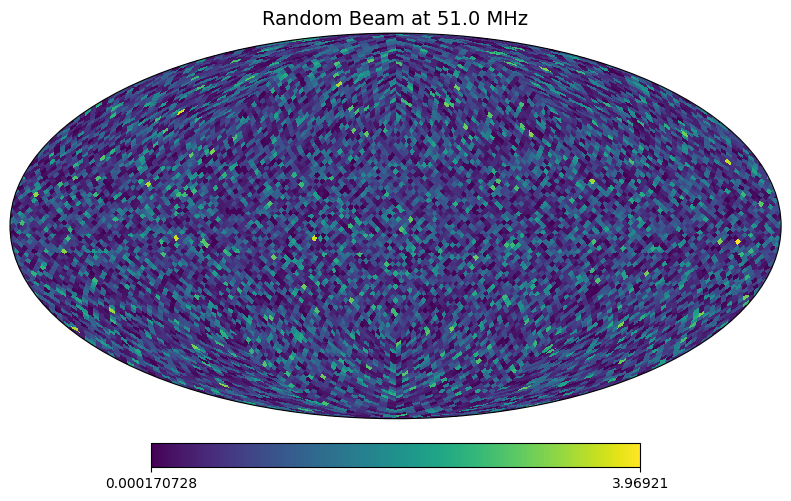

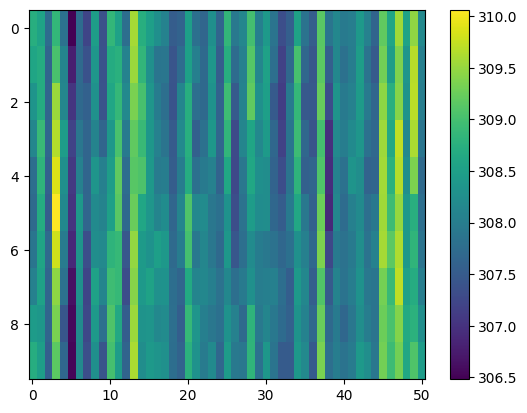

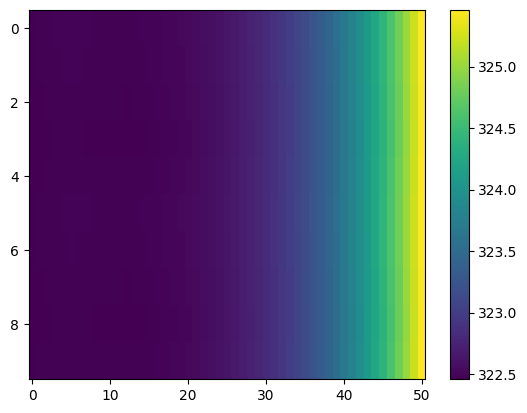

In [4]:
key = jax.random.PRNGKey(42)
random_beam = jnp.abs(jax.random.normal(key, shape = (vivaldi_hp.shape)))

def water_maker(beam, pars):
    print(beam.shape, pars.shape)
    # beam = beam.at[:].add(pars)
    beam += pars
    # beam[:] += pars
    beam_alm = jax.vmap(beam2alm)(beam)
    print(beam_alm.shape)
    # print(jnp.max(beam_alm))
    norm = crojax.alm.total_power(beam_alm, lmax)
    print(norm)
    print('pre waterfall')
    waterfall = crojax.simulator.convolve(beam_alm, sky_alm, phases).real / norm
    print('post waterfall')
    return waterfall

zero_pars = jnp.full(random_beam.shape, 0, dtype=jnp.float64)

projview(m=random_beam[1], title=f"Random Beam at {freq[1]} MHz")
plt.figure()
plt.imshow(water_maker(random_beam, zero_pars), aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(vis, aspect='auto')
plt.colorbar()

plt.show()

In [5]:
@jax.jit
def loss_fcn(pars):
    fit = water_maker(random_beam, pars)
    return jnp.sum(jnp.abs(vis**2 - fit**2)) / random_beam.size

loss_grad = jax.grad(loss_fcn)

In [ ]:
p0 = jnp.full(random_beam.shape, 300, dtype=jnp.float64)



def fit(max_iter, learning_rate, initial_par=p0):
    """
    The fitting loop.

    Parameters
    ----------
    max_iter : int
        Number of iterations in the loop.
    learning_rate : float
        Hyperparameter that sets the step size (how much we update the parameters at each step)
    initial_par : ndarray
        The initial guess for the parameters.

    Returns
    -------
    par_vals : ndarray
        The parameter at each iteration.
    loss_vals : ndarray
        The value of the loss at each iteration.
    grad_vals : ndarray
        The value of the gradient of the loss at each iteraiton.
    
    """
    par_vals = []
    loss_vals = []
    grad_vals = []

    par = initial_par
    
    for step in trange(max_iter):
        # my_beam = beam_maker(random_beam, par)
        loss = loss_fcn(par)
        # print('loss')
        grad = loss_grad(par)
        # print('grad')
        loss_vals.append(loss)
        grad_vals.append(grad)
        par -= learning_rate * grad
        # print('par shape', par.shape)
        par_vals.append(par)
        # my_beam = beam_maker(random_beam, par)

    par_vals = jnp.array(par_vals)
    loss_vals = jnp.array(loss_vals)
    grad_vals = jnp.array(grad_vals)
    return par_vals, loss_vals, grad_vals

# param_list = []
# lost_list = []

# for i in range(ntimes):
#     par_vals, loss_vals, grad_vals = fit(2, .0001, i, p0)
#     param_list.append(par_vals)
#     lost_list.append(loss_vals)
    
# param_arr = jnp.array(param_list)
# lost_arr = jnp.array(lost_list)
# print(param_arr.shape, lost_arr.shape)
par_vals, loss_vals, grad_vals = fit(500, .0001, p0)

  0%|          | 0/500 [00:00<?, ?it/s]

(51, 12288) (51, 12288)
(51, 65, 129)
Traced<ShapedArray(float64[51])>with<DynamicJaxprTrace(level=1/0)>
pre waterfall
post waterfall
